In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

# EarlyStopping

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

save_best_model = ModelCheckpoint("wagi_best.h5py",save_best_only=True)
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, save_best_model, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
941/943 [============================>.] - ETA: 0s - loss: 0.4338 - accuracy: 0.8059WARNING:tensorflow:From C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow

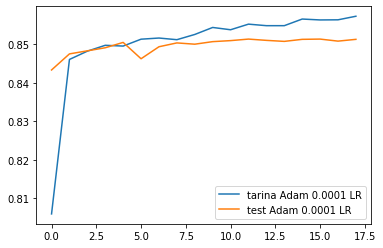

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam 0.0001 LR")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam 0.0001 LR")


plt.legend()
plt.show()

In [7]:
model.load_weights("wagi_best.h5py")
model.evaluate(X_test,y_test)

# Zad.
Do poniższych danych dobierz paametr
```python
patience=
```

Zwizualizuj wyniki dla obu modeli.

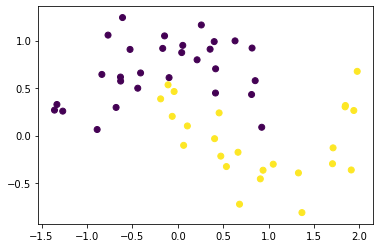

In [8]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [9]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.8291 - accuracy: 0.3774 - val_loss: 0.6743 - val_accuracy: 0.5532
Epoch 2/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.6937 - accuracy: 0.4717 - val_

2/2 [==============================] - 0s 16ms/step - loss: 0.1903 - accuracy: 0.9245 - val_loss: 0.4762 - val_accuracy: 0.8298
Epoch 53/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1916 - accuracy: 0.9057 - val_loss: 0.4826 - val_accuracy: 0.8298
Epoch 54/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1906 - accuracy: 0.9245 - val_loss: 0.4725 - val_accuracy: 0.8298
Epoch 55/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1860 - accuracy: 0.9245 - val_loss: 0.4753 - val_accuracy: 0.8298
Epoch 56/1000
2/2 [==============================] - 0s 11ms/step - loss: 0.1866 - accuracy: 0.9057 - val_loss: 0.4772 - val_accuracy: 0.8298
Epoch 57/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1829 - accuracy: 0.9245 - val_loss: 0.4653 - val_accuracy: 0.8298
Epoch 58/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1821 - accuracy: 0.9245 - val_loss: 0.4529 - val_accuracy: 0.8298
Epoch 59/1000
2/2 [=

Epoch 110/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0689 - accuracy: 0.9811 - val_loss: 0.2208 - val_accuracy: 0.8936
Epoch 111/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0648 - accuracy: 0.9811 - val_loss: 0.2335 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0628 - accuracy: 0.9811 - val_loss: 0.2455 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0634 - accuracy: 0.9811 - val_loss: 0.2538 - val_accuracy: 0.9149
Epoch 114/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0616 - accuracy: 0.9811 - val_loss: 0.2358 - val_accuracy: 0.9149
Epoch 115/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0590 - accuracy: 0.9811 - val_loss: 0.2149 - val_accuracy: 0.8936
Epoch 116/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0601 - accuracy: 1.0000 - val_loss: 0.2030 - val_accuracy: 0.8936

2/2 [==============================] - 0s 16ms/step - loss: 0.0221 - accuracy: 1.0000 - val_loss: 0.1945 - val_accuracy: 0.9362
Epoch 168/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.1798 - val_accuracy: 0.9149
Epoch 169/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.1713 - val_accuracy: 0.9149
Epoch 170/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.1717 - val_accuracy: 0.9149
Epoch 171/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.1747 - val_accuracy: 0.9149
Epoch 172/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.1812 - val_accuracy: 0.9149
Epoch 173/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.1896 - val_accuracy: 0.9149
Epoch 174/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.1983 - val_accuracy: 0.8936
Epoch 225/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1999 - val_accuracy: 0.8936
Epoch 226/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.1993 - val_accuracy: 0.9149
Epoch 227/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.2011 - val_accuracy: 0.9149
Epoch 228/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.2043 - val_accuracy: 0.8936
Epoch 229/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.2071 - val_accuracy: 0.8936
Epoch 230/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.2070 - val_accuracy: 0.8936
Epoch 231/1000

2/2 [==============================] - 0s 18ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2164 - val_accuracy: 0.9149
Epoch 282/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.2178 - val_accuracy: 0.9149
Epoch 283/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.2185 - val_accuracy: 0.9149
Epoch 284/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2195 - val_accuracy: 0.9149
Epoch 285/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2188 - val_accuracy: 0.9149
Epoch 286/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2176 - val_accuracy: 0.9149
Epoch 287/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2170 - val_accuracy: 0.9149
Epoch 288/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2307 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2329 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2329 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2330 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2327 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2331 - val_accuracy: 0.9149
Epoch 344/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2332 - val_accuracy: 0.9149
Epoch 345/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2498 - val_accuracy: 0.9149
Epoch 396/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2497 - val_accuracy: 0.9149
Epoch 397/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2499 - val_accuracy: 0.9149
Epoch 398/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2490 - val_accuracy: 0.9149
Epoch 399/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2497 - val_accuracy: 0.9149
Epoch 400/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2503 - val_accuracy: 0.9149
Epoch 401/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2511 - val_accuracy: 0.9149
Epoch 402/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2637 - val_accuracy: 0.9149
Epoch 453/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2619 - val_accuracy: 0.9149
Epoch 454/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2612 - val_accuracy: 0.9149
Epoch 455/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2619 - val_accuracy: 0.9149
Epoch 456/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2634 - val_accuracy: 0.9149
Epoch 457/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2649 - val_accuracy: 0.9149
Epoch 458/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2664 - val_accuracy: 0.9149
Epoch 459/1000

2/2 [==============================] - 0s 13ms/step - loss: 9.6556e-04 - accuracy: 1.0000 - val_loss: 0.2779 - val_accuracy: 0.9149
Epoch 510/1000
2/2 [==============================] - 0s 13ms/step - loss: 9.9588e-04 - accuracy: 1.0000 - val_loss: 0.2780 - val_accuracy: 0.9149
Epoch 511/1000
2/2 [==============================] - 0s 14ms/step - loss: 9.6452e-04 - accuracy: 1.0000 - val_loss: 0.2791 - val_accuracy: 0.9149
Epoch 512/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2812 - val_accuracy: 0.9149
Epoch 513/1000
2/2 [==============================] - 0s 13ms/step - loss: 9.8777e-04 - accuracy: 1.0000 - val_loss: 0.2816 - val_accuracy: 0.9149
Epoch 514/1000
2/2 [==============================] - 0s 16ms/step - loss: 9.9185e-04 - accuracy: 1.0000 - val_loss: 0.2803 - val_accuracy: 0.9149
Epoch 515/1000
2/2 [==============================] - 0s 13ms/step - loss: 9.3623e-04 - accuracy: 1.0000 - val_loss: 0.2801 - val_accurac

Epoch 565/1000
2/2 [==============================] - 0s 12ms/step - loss: 7.4006e-04 - accuracy: 1.0000 - val_loss: 0.2914 - val_accuracy: 0.9149
Epoch 566/1000
2/2 [==============================] - 0s 12ms/step - loss: 7.4424e-04 - accuracy: 1.0000 - val_loss: 0.2916 - val_accuracy: 0.9149
Epoch 567/1000
2/2 [==============================] - 0s 12ms/step - loss: 7.6501e-04 - accuracy: 1.0000 - val_loss: 0.2904 - val_accuracy: 0.9149
Epoch 568/1000
2/2 [==============================] - 0s 12ms/step - loss: 7.5113e-04 - accuracy: 1.0000 - val_loss: 0.2904 - val_accuracy: 0.9149
Epoch 569/1000
2/2 [==============================] - 0s 12ms/step - loss: 7.2811e-04 - accuracy: 1.0000 - val_loss: 0.2914 - val_accuracy: 0.9149
Epoch 570/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.2249e-04 - accuracy: 1.0000 - val_loss: 0.2934 - val_accuracy: 0.9149
Epoch 571/1000
2/2 [==============================] - 0s 12ms/step - loss: 7.2439e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 621/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.9327e-04 - accuracy: 1.0000 - val_loss: 0.3015 - val_accuracy: 0.9149
Epoch 622/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.9022e-04 - accuracy: 1.0000 - val_loss: 0.3024 - val_accuracy: 0.9149
Epoch 623/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.6991e-04 - accuracy: 1.0000 - val_loss: 0.3024 - val_accuracy: 0.9149
Epoch 624/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.6840e-04 - accuracy: 1.0000 - val_loss: 0.3028 - val_accuracy: 0.9149
Epoch 625/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.7586e-04 - accuracy: 1.0000 - val_loss: 0.3028 - val_accuracy: 0.9149
Epoch 626/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.8495e-04 - accuracy: 1.0000 - val_loss: 0.3039 - val_accuracy: 0.9149
Epoch 627/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.7371e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 677/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.7165e-04 - accuracy: 1.0000 - val_loss: 0.3158 - val_accuracy: 0.9149
Epoch 678/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.5646e-04 - accuracy: 1.0000 - val_loss: 0.3137 - val_accuracy: 0.9149
Epoch 679/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.5303e-04 - accuracy: 1.0000 - val_loss: 0.3118 - val_accuracy: 0.9149
Epoch 680/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.5297e-04 - accuracy: 1.0000 - val_loss: 0.3108 - val_accuracy: 0.9149
Epoch 681/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.8185e-04 - accuracy: 1.0000 - val_loss: 0.3099 - val_accuracy: 0.9149
Epoch 682/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.6485e-04 - accuracy: 1.0000 - val_loss: 0.3109 - val_accuracy: 0.9149
Epoch 683/1000
2/2 [==============================] - 0s 12ms/step - loss: 4.7383e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 733/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.8106e-04 - accuracy: 1.0000 - val_loss: 0.3177 - val_accuracy: 0.9149
Epoch 734/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.0049e-04 - accuracy: 1.0000 - val_loss: 0.3172 - val_accuracy: 0.9149
Epoch 735/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.8851e-04 - accuracy: 1.0000 - val_loss: 0.3190 - val_accuracy: 0.9149
Epoch 736/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.8729e-04 - accuracy: 1.0000 - val_loss: 0.3212 - val_accuracy: 0.9149
Epoch 737/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.6707e-04 - accuracy: 1.0000 - val_loss: 0.3226 - val_accuracy: 0.9149
Epoch 738/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.6367e-04 - accuracy: 1.0000 - val_loss: 0.3237 - val_accuracy: 0.9149
Epoch 739/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.6280e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 789/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.0523e-04 - accuracy: 1.0000 - val_loss: 0.3320 - val_accuracy: 0.9149
Epoch 790/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.0728e-04 - accuracy: 1.0000 - val_loss: 0.3319 - val_accuracy: 0.9149
Epoch 791/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.0601e-04 - accuracy: 1.0000 - val_loss: 0.3314 - val_accuracy: 0.9149
Epoch 792/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.1167e-04 - accuracy: 1.0000 - val_loss: 0.3314 - val_accuracy: 0.9149
Epoch 793/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.0513e-04 - accuracy: 1.0000 - val_loss: 0.3330 - val_accuracy: 0.9149
Epoch 794/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.1005e-04 - accuracy: 1.0000 - val_loss: 0.3345 - val_accuracy: 0.9149
Epoch 795/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.0140e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 845/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.5903e-04 - accuracy: 1.0000 - val_loss: 0.3423 - val_accuracy: 0.9149
Epoch 846/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.5970e-04 - accuracy: 1.0000 - val_loss: 0.3417 - val_accuracy: 0.9149
Epoch 847/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.5325e-04 - accuracy: 1.0000 - val_loss: 0.3421 - val_accuracy: 0.9149
Epoch 848/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.5248e-04 - accuracy: 1.0000 - val_loss: 0.3424 - val_accuracy: 0.9149
Epoch 849/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.5525e-04 - accuracy: 1.0000 - val_loss: 0.3425 - val_accuracy: 0.9149
Epoch 850/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.5108e-04 - accuracy: 1.0000 - val_loss: 0.3433 - val_accuracy: 0.9149
Epoch 851/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.5218e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 901/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.1586e-04 - accuracy: 1.0000 - val_loss: 0.3489 - val_accuracy: 0.9149
Epoch 902/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.1597e-04 - accuracy: 1.0000 - val_loss: 0.3495 - val_accuracy: 0.9149
Epoch 903/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.1481e-04 - accuracy: 1.0000 - val_loss: 0.3508 - val_accuracy: 0.9149
Epoch 904/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.2072e-04 - accuracy: 1.0000 - val_loss: 0.3517 - val_accuracy: 0.9149
Epoch 905/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.1504e-04 - accuracy: 1.0000 - val_loss: 0.3515 - val_accuracy: 0.9149
Epoch 906/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.1345e-04 - accuracy: 1.0000 - val_loss: 0.3508 - val_accuracy: 0.9149
Epoch 907/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.1267e-04 - accuracy: 1.0000 - val_loss: 0

2/2 [==============================] - 0s 15ms/step - loss: 1.8567e-04 - accuracy: 1.0000 - val_loss: 0.3584 - val_accuracy: 0.9149
Epoch 957/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.8517e-04 - accuracy: 1.0000 - val_loss: 0.3578 - val_accuracy: 0.9149
Epoch 958/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.8477e-04 - accuracy: 1.0000 - val_loss: 0.3575 - val_accuracy: 0.9149
Epoch 959/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.8798e-04 - accuracy: 1.0000 - val_loss: 0.3572 - val_accuracy: 0.9149
Epoch 960/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.8396e-04 - accuracy: 1.0000 - val_loss: 0.3578 - val_accuracy: 0.9149
Epoch 961/1000
2/2 [==============================] - 0s 14ms/step - loss: 1.8348e-04 - accuracy: 1.0000 - val_loss: 0.3586 - val_accuracy: 0.9149
Epoch 962/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.8370e-04 - accuracy: 1.0000 - val_loss: 0.3589 - val_acc

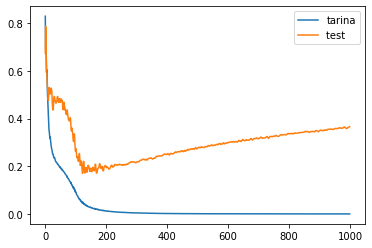

In [10]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


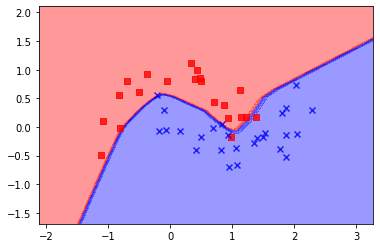

In [11]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Zad

Do powyższego modelu dodaj EarlyStopping:

```python
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)
```